<a href="https://colab.research.google.com/github/ProfPaiMau/EmbAIProj1/blob/main/EmbeddedAIOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv


In [16]:
#Importar o core do tensorflow

import tensorflow as tf
import datetime

#Importacao das layerss para construir CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

#Importar para data pre-processing... load image, data aug etc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#outrods
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import cv2

In [6]:
#Função para desenhar imagens

### defining some function to make our work easier
import matplotlib.pyplot as plt

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plot_images(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.reshape(imageWidth, imageHeight), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [7]:
batch_size = 32 #num imagens a processar ao mesmo tempo
epochs = 50 # Numero de vezes que vai fazer o training de todo o dataset
IMG_HEIGHT = 28 #target resize
IMG_WIDTH = 28 # target resize

In [8]:
# Gera imagens para melhorar o training e reduzir o overfitting, aplicando:
#  - variacoes com data augmentation (tilted, zoom, scaled, moved)

augmented_image_gen = ImageDataGenerator(
        rescale = 1/255.0,
    rotation_range=2,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=0.1,
    shear_range=2,
    brightness_range=[0.9, 1.1],
    validation_split=0.2,

   )

#Normaliza imagens para validacao
normal_image_gen = ImageDataGenerator(
    rescale = 1/255.0,
    validation_split=0.2,

   )

In [9]:
train_data_gen = augmented_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="/content/drive/MyDrive/PhdData/Daniel/standardOCR/data/training_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='training')
val_data_gen = normal_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="/content/drive/MyDrive/PhdData/Daniel/standardOCR/data/testing_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='validation')

Found 16534 images belonging to 36 classes.
Found 180 images belonging to 36 classes.


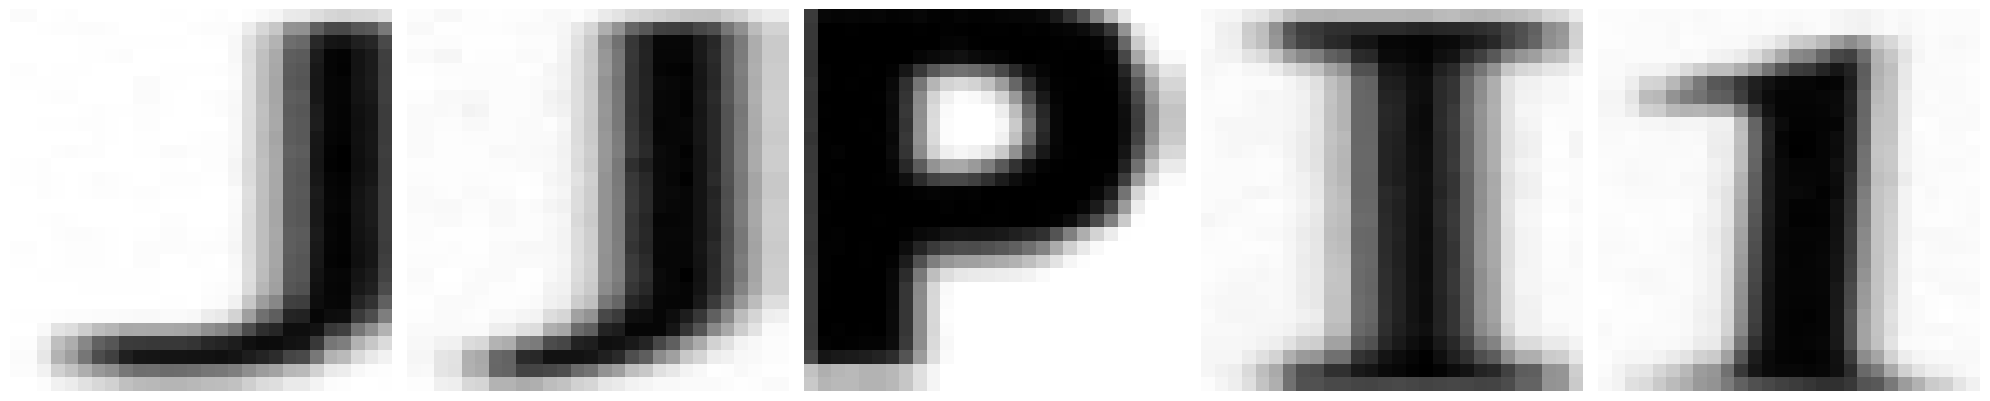

In [10]:
#Fazer um sample para teste se ta tudo ok
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:7], IMG_WIDTH, IMG_HEIGHT)

In [11]:
# Modelo CCN com um stack linear de camadas

from tensorflow.keras.optimizers import SGD
# define cnn model
def define_model():
    model = Sequential()

    # Adicionar a convulotion layaer tal como explicado Slide 1.6, Sessao 2, pag 30
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    # Adicionar a MAx pooling layaer tal como explicado Slide 1.6, Sessao 2, pag 31
    model.add(MaxPooling2D((2, 2)))
    # Addflatten layer serve para converter 2D para 1D
    model.add(Flatten())

    # Layer que define o fully connected, 100 neuroms !?!, page 32???
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # Layer que define a softmax layer, 36 uma saida para cada letra, softmax para multi-class!?!, pag 33
    model.add(Dense(36, activation='softmax'))
    return model

In [12]:
model = define_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
#Callbacks the que antecipam o termino do calculo

import tensorflow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

#Prepare call backs
EarlyStop_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/OCRDataSet2/model.keras',
                             monitor = 'val_loss',mode = 'min',save_best_only= True)
lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5,patience = 3,min_lr = 0.00001)
my_callback=[EarlyStop_callback,checkpoint]

In [ ]:
#Treino do modelo

# Falha em reconhecer lr0.01
#model.compile(optimizer=SGD(lr=0.01, momentum=0.9),
#              loss=tf.keras.losses.CategoricalCrossentropy(),
#              metrics=['categorical_accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=32,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=my_callback
)

Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 42/516 ━━━━━━━━━━━━━━━━━━━━ 1:36:56 12s/step - categorical_accuracy: 0.0431 - loss: 3.6808

In [ ]:
#Plots dos resultado explicados em baixo

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(32)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()